#### Downloading & Inspecting EUMETSAT/MSG Data

Code adapted from https://eumetsatspace.atlassian.net/wiki/spaces/EUMDAC/pages/1760198661/Python+Library

Requires signing up for an account with EUMETSAT EO Portal: https://eoportal.eumetsat.int/userMgmt/
Once done, the consumer key and secret can be found under the user information: https://eumetsatspace.atlassian.net/wiki/spaces/DSEV/pages/375652353/API+Authentication

In [ ]:
import autoroot

In [74]:
import os
import ast
import eumdac
import datetime
import shutil
import pyproj
import rioxarray
import rasterio
import xarray as xr
import matplotlib.pyplot as plt

from pyproj import CRS

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Insert your personal key and secret into the single quotes
consumer_key = ""
consumer_secret = ""

credentials = (consumer_key, consumer_secret)

token = eumdac.AccessToken(credentials)

print(f"This token '{token}' expires {token.expiration}")

In [ ]:
datastore = eumdac.DataStore(token)
datastore.collections

In [ ]:
type(datastore)

##### Define download parameters & compile list of products

SEVIRI Data Products

In [ ]:
selected_collection = datastore.get_collection('EO:EUM:DAT:MSG:HRSEVIRI')
selected_collection.search()

In [ ]:
# Add vertices for polygon, wrapping back to the start point.
# geometry = [[-1.0, -1.0],[4.0, -4.0],[8.0, -2.0],[9.0, 2.0],[6.0, 4.0],[1.0, 5.0],[-1.0, -1.0]]

# Set sensing start and end time
# start = datetime.datetime(2021, 10, 10, 0, 0, 0)
# end = datetime.datetime(2021, 10, 10, 23, 59, 59)
start = datetime.datetime.strptime("2018-10-01 00:10:00", "%Y-%m-%d %H:%M:%S")
# end = datetime.datetime.strptime("2021-10-10 12:59:00", "%Y-%m-%d %H:%M:%S")

# Retrieve datasets that match our filter
products = selected_collection.search(
    # geo='POLYGON(({}))'.format(','.join(["{} {}".format(*coord) for coord in geometry])),
    dtstart=start,
    dtend=start,
    # dtend=end,
    sort="start,time,1")
    
print(f'Found Datasets: {len(products)} datasets for the given time range')

for product in products:
    print(product)

Cloud Mask Data Products

In [ ]:
selected_collection = datastore.get_collection('EO:EUM:DAT:MSG:CLM')
selected_collection.search()

In [ ]:
# Add vertices for polygon, wrapping back to the start point.
# geometry = [[-1.0, -1.0],[4.0, -4.0],[8.0, -2.0],[9.0, 2.0],[6.0, 4.0],[1.0, 5.0],[-1.0, -1.0]]

# Set sensing start and end time
# start = datetime.datetime(2021, 10, 10, 0, 0, 0)
# end = datetime.datetime(2021, 10, 10, 23, 59, 59)
start = datetime.datetime.strptime("2018-10-01 00:15:00", "%Y-%m-%d %H:%M:%S")
# end = datetime.datetime.strptime("2021-10-10 12:59:00", "%Y-%m-%d %H:%M:%S")

# Retrieve datasets that match our filter
products = selected_collection.search(
    # geo='POLYGON(({}))'.format(','.join(["{} {}".format(*coord) for coord in geometry])),
    dtstart=start,
    dtend=start,
    # dtend=end,
    sort="start,time,1")
    
print(f'Found Datasets: {len(products)} datasets for the given time range')

for product in products:
    print(product)
for entry in product.entries:
    print(entry)

##### Download products

Each product contains three files (EOPMetadata.xml, manifest.xml, and data.nat files). When downloading the whole product, a .zip folder is created.

In [ ]:
for product in products:
    with product.open() as fsrc, \
            open(fsrc.name, mode='wb') as fdst:
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of product {product} finished.')
print('All downloads are finished.')

In [ ]:
for product in products:    
    print(product.url)

##### Download only selected products & files

##### Testing SEVIRI Data Downloader

In [ ]:
selected_product = datastore.get_product(
    product_id='MSG4-SEVI-MSG15-0100-NA-20211110081242.766000000Z-NA',
    collection_id='EO:EUM:DAT:MSG:HRSEVIRI')

In [ ]:
selected_product

The data is stored in a .nat file

In [ ]:
for entry in selected_product.entries:
    print(entry)

In [ ]:
try:
    with selected_product.open(entry='MSG4-SEVI-MSG15-0100-NA-20211110081242.766000000Z-NA.nat') as fsrc, \
            open(fsrc.name, mode='wb') as fdst:
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of file {fsrc.name} finished.')
except eumdac.product.ProductError as error:
    print(f"Error related to the product '{selected_product}' while trying to download it: '{error.msg}'")

In [ ]:
try:
    with selected_product.open(entry='EOPMetadata.xml') as fsrc, \
            open(fsrc.name, mode='wb') as fdst:
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of file {fsrc.name} finished.')
except eumdac.product.ProductError as error:
    print(f"Error related to the product '{selected_product}' while trying to download it: '{error.msg}'")

Unfortunately, .nat files are a bit complicated to read/load. One of the best packages is satpy, which then allows loading the files using xarray.

In [ ]:
from satpy import Scene
scn = Scene(reader="seviri_l1b_native", filenames=['MSG4-SEVI-MSG15-0100-NA-20211110081242.766000000Z-NA.nat'])

In [ ]:
# MSG data contains 12 channels, including the high-resolution visible (HRV) channel.
datasets = scn.available_dataset_names()
datasets

In order to convert the scn object to xarray, each dataset needs to be loaded.

In [ ]:
scn.load(datasets[1:], generate=False)
# Note: The HRV channel comes in 1 km resolution, while the other channels are 3 km resolution.
# Because of the size mismatch, the HRV channel would either need to be downscaled,
# or it needs to the loaded separetely to the other channels


In [ ]:
ds = scn.to_xarray()

In [ ]:
# The grb reader doesn't seem to be able to open this file
scn = Scene(reader="grib", filenames=['MSG4-SEVI-MSGCLMK-0100-0100-20181001001500.000000000Z-NA.grb'])

##### Testing Cloud Mask Downloader

The data is stored in a .grb file

In [ ]:
selected_product = datastore.get_product(
    product_id='MSG4-SEVI-MSGCLMK-0100-0100-20181001001500.000000000Z-NA',
    collection_id='EO:EUM:DAT:MSG:CLM')

In [ ]:
try:
    with selected_product.open(entry='MSG4-SEVI-MSGCLMK-0100-0100-20181001001500.000000000Z-NA.grb') as fsrc, \
            open(fsrc.name, mode='wb') as fdst:
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of file {fsrc.name} finished.')
except eumdac.product.ProductError as error:
    print(f"Error related to the product '{selected_product}' while trying to download it: '{error.msg}'")

In [71]:
import pygrib
# Open the GRIB file
grbs = pygrib.open('MSG4-SEVI-MSGCLMK-0100-0100-20181001001500.000000000Z-NA.grb')

# Loop over all messages in the GRIB file
for grb in grbs:
    # Print some metadata
    print(grb.name)
    print(grb.validDate)
    print(grb.analDate)
    # Get the data as a 2D numpy array
    data = grb.values

    # Print the shape and some of the data
    print(data.shape)
    print(data[0, 0])


Cloud mask
None
2018-10-01 00:15:00
(3712, 3712)
3.0


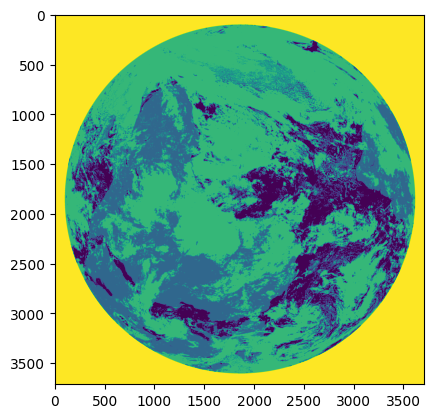

In [79]:
plt.imshow(data)

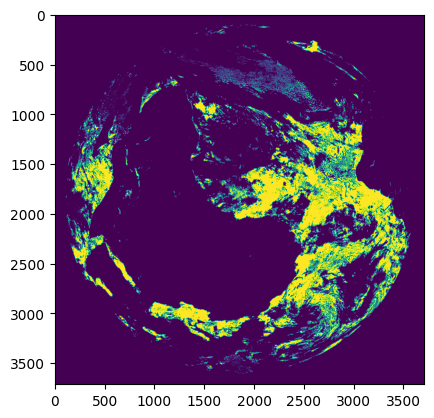

In [81]:
plt.imshow(data == 0) # Clear sky over land

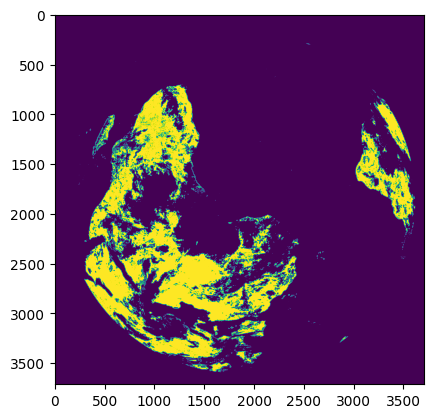

In [82]:
plt.imshow(data == 1) # Clear sky over water

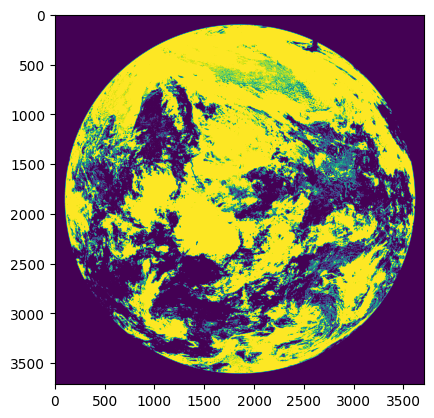

In [83]:
plt.imshow(data == 2) # Cloud

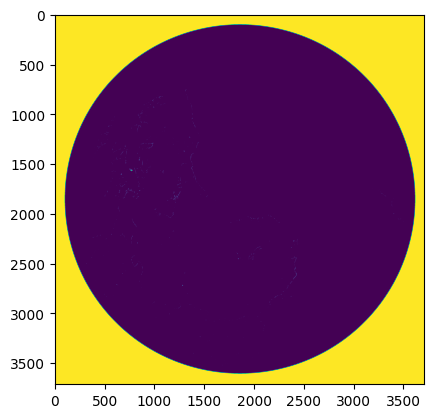

In [85]:
plt.imshow(data == 3) # not processed